# characterize political threads in subreddits

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import sqlite3
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
from itertools import combinations
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from utils import ROOTPATH, build_df_year, generate_index

In [7]:
df2012 = build_df_year(2012, with_text=True, with_time=True)
generate_index()

from utils import USERS, SUBREDDITS, user2index, index2user, subr2index, index2subr

building base dataframe for year 2012...
- fetching submissions for year 2012
- fetching comments for year 2012


## aggregate by submission

In [14]:
aggr_func = {"comment_id": lambda x: list(x), "toxicity": np.mean}
groupby_subm = df2012.groupby("submission_id").agg(aggr_func).reset_index()
groupby_subm["n_comments"] = groupby_subm["comment_id"].map(lambda x: len(x))

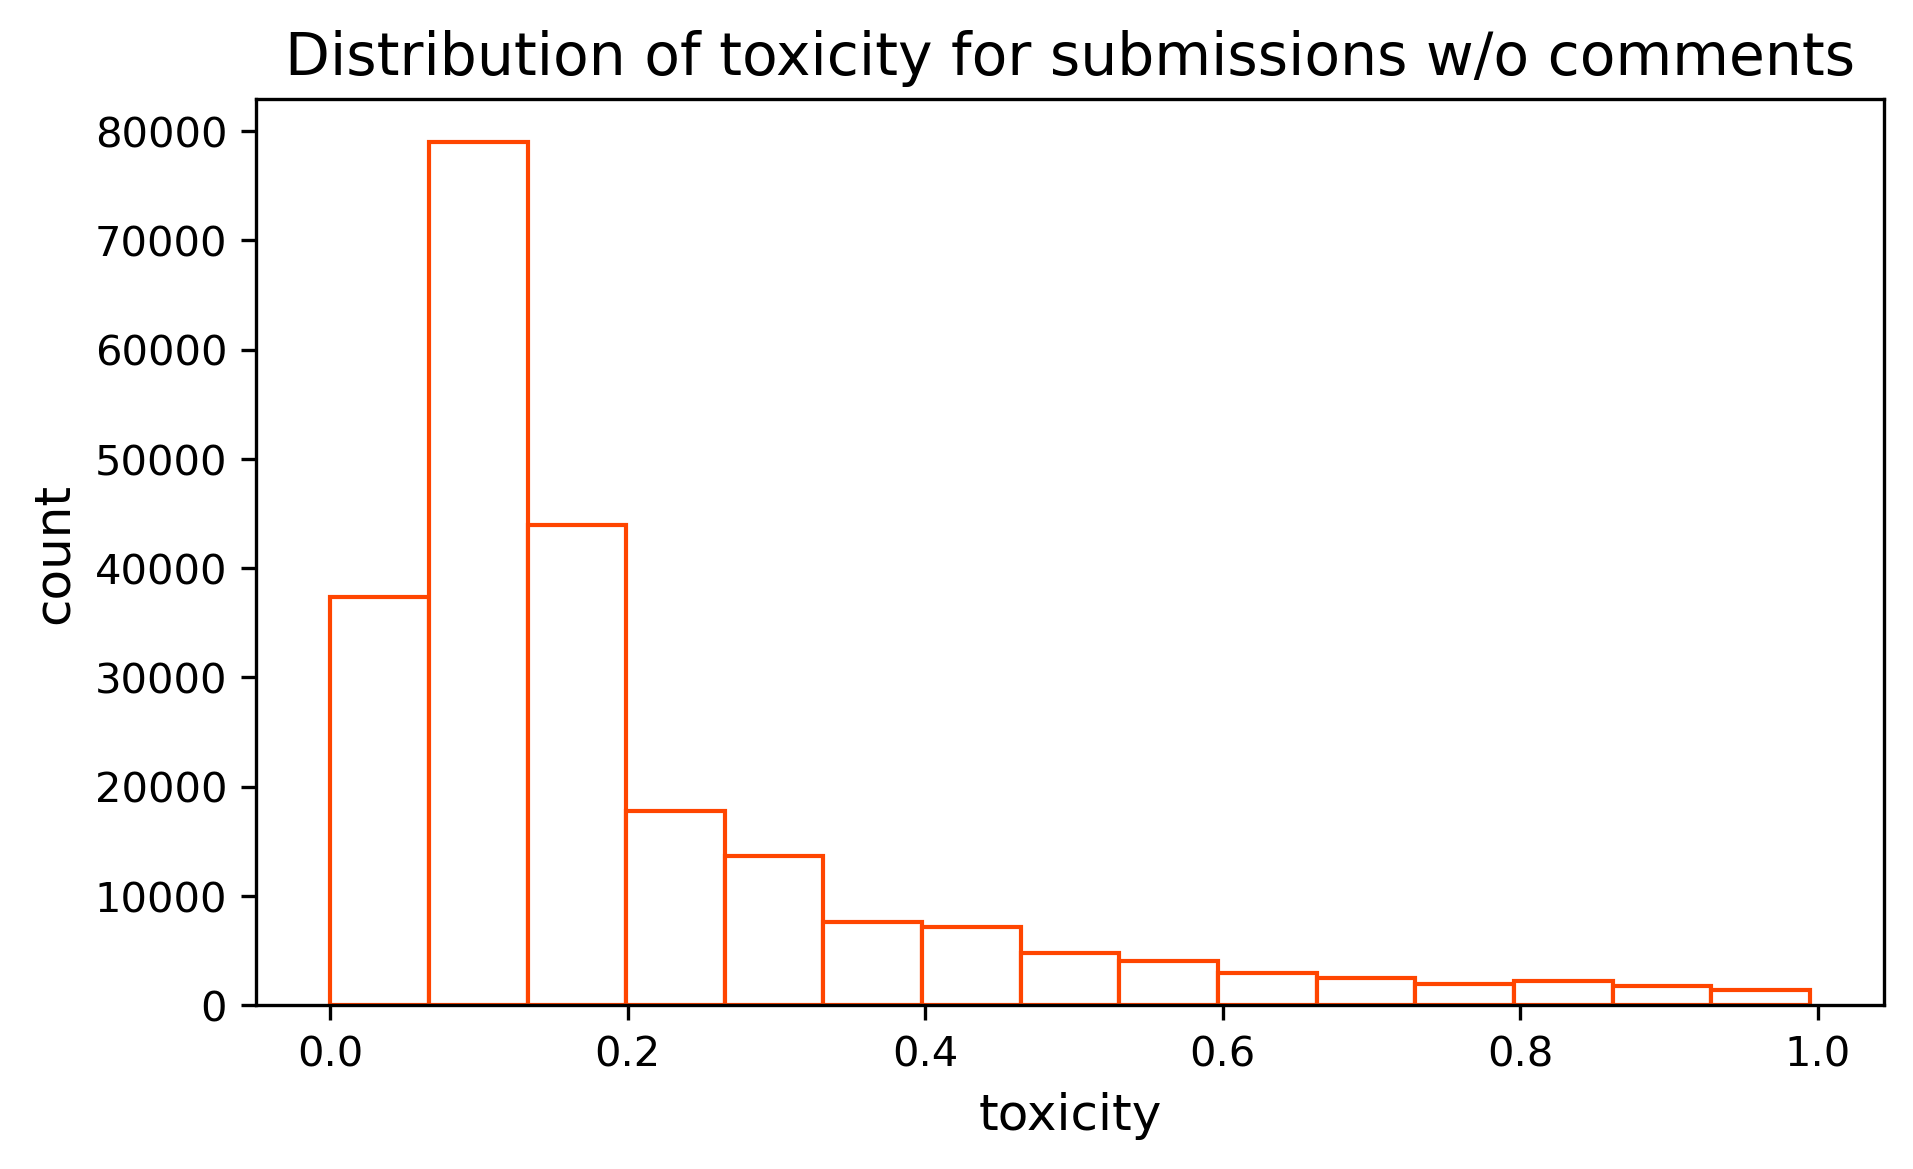

In [43]:
# toxicity score for submissions that have no comment
fig,ax = plt.subplots(figsize=(7,4),dpi=300)
plt.hist(groupby_subm[groupby_subm["n_comments"]==1]["toxicity"], bins=15, color="white", ec="#FF4500")
plt.xlabel("toxicity", fontsize=12)
plt.ylabel("count", fontsize=12)
plt.title("Distribution of toxicity for submissions w/o comments", fontsize=14)
plt.savefig(ROOTPATH + "output/fig/toxicity_distr_subm0comm.png", dpi=300)

In [44]:
groupby_subm

,submission_id,comment_id,toxicity,n_comments
0,10002y,[nan],0.091373,1
1,10003q,[nan],0.118541,1
2,1000ba,[nan],0.112425,1
3,1000ce,"[nan, c696q84, c696srf, c696ydr, c69788m, c697...",0.305280,10
4,1000en,"[nan, c696wf6, c6970rg, c697tt5, c698m6s, c698...",0.140055,17
...,...,...,...,...
469346,zzzsk,[nan],0.092025,1
469347,zzzte,"[nan, c69823f, c69btx6, c69e09r]",0.098064,4
469348,zzzus,"[nan, c696l2y, c69cr9s]",0.499527,3
469349,zzzw7,"[nan, c696olg, c696pd0, c696zp6, c6975ul, c69a...",0.295075,12


## build tree graphs

In [ ]:
df2012

In [ ]:
# build tree graphs for submissions with at least one comments
df2012[["submission_id","comment_id", "parent_id"]].dropna()
# def build_tree_graph(subm_id):
    